In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re

In [7]:
def reset_timestamp(df):
    df['timestamp'] = df['timestamp'] - df['timestamp'][0]
    return df

def process_line(line):
    timestamp = line.split(' ')[1]
    content = line.split('  : ')[1]
    pairs = content.split(',')

    d = {}

    cpugpu = re.search("CPU4/GPU=\d+/\d+,\d+/\d+", content).group()
    cpugpu = cpugpu.split('=')[1]
    cpugpu = cpugpu.split('/')

    d['CPU Level'] = int(cpugpu[0])
    d['GPU Level'] = int(cpugpu[1].split(',')[0])
    d['CPU Frequency (MHz)'] = int(cpugpu[1].split(',')[1])
    d['GPU Frequency (MHz)'] = int(cpugpu[2])
    
    for x in pairs:
        tmp = x.split('=')
        if tmp[0] == 'CPU4/GPU' or len(tmp) < 2:
            continue
        if tmp[0] == 'FPS':
            d[tmp[0]] = int(tmp[1].split('/')[0])
        elif tmp[0] == 'Free':
            d[tmp[0]] = int(tmp[1][:-2])
        else:
            d[tmp[0]] = tmp[1].strip()

    d["timestamp"] = timestamp

    return pd.DataFrame(d, index=[0])

def add_to_dataframe(df, timestamp, key, value):
    if key not in df.columns:
        df[key] = np.nan
    df.loc[timestamp, key] = value
    return df

def create_dataframe(file_path):
    df = pd.DataFrame()
    for line in open(file_path, 'r', encoding='utf-16'):
        if len(line) < 300:
            continue
        new_d = process_line(line)
        df = pd.concat([df, new_d])

    folder = file_path.split('\\')
    folder[0] = folder[0][19:-4]

    df['experiment'] = folder[0]
    df['device'] = folder[1]
    df['repetition'] = folder[4]

    df.to_csv(f'.{file_path.strip(".log")}.csv', index=False)

    return df

def process_logcat():
    df_aggregated = pd.DataFrame()
    for root, dirs, files in os.walk("./", topdown=False):
        for name in files:
            if(name == 'logcat_VrApi.log') and ("clumsy-bandwidth" in os.path.join(root, name)):
                # print(os.path.join(root, name))
                df_aggregated = pd.concat([df_aggregated, create_dataframe(os.path.join(root, name))])

            if (name == "logcat_VrApi.log") and ("overhead-validation" in os.path.join(root, name)):
                print(os.path.join(root, name))
                df_aggregated = pd.concat([df_aggregated, create_dataframe(os.path.join(root, name))])


    return df_aggregated

df_aggregate = process_logcat()

./overhead-validation\Quest-2\BeatSaber\PopStars-Medium\baseline0\logcat_VrApi.log
./overhead-validation\Quest-2\BeatSaber\PopStars-Medium\baseline1\logcat_VrApi.log
./overhead-validation\Quest-2\BeatSaber\PopStars-Medium\baseline2\logcat_VrApi.log
./overhead-validation\Quest-2\BeatSaber\PopStars-Medium\record0\logcat_VrApi.log
./overhead-validation\Quest-2\BeatSaber\PopStars-Medium\record1\logcat_VrApi.log
./overhead-validation\Quest-2\BeatSaber\PopStars-Medium\record2\logcat_VrApi.log
./overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.0\logcat_VrApi.log
./overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.1\logcat_VrApi.log
./overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.2\logcat_VrApi.log
./overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.3\logcat_VrApi.log
./overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.4\logcat_VrApi.log
./overhead-validation\Quest-2\BeatSaber\PopStars-Medium\replay0.5\logcat_VrApi.log
./overhead

In [18]:
plt.rcParams['font.family'] = 'Arial'
custom_params = {"axes.spines.right": False, 
                 "axes.spines.top": False,
                 "axes.spines.left": True,
                 "axes.spines.bottom": True,
                #create dashes next to ticks
                 "xtick.bottom": True,
                 "ytick.left": True,
                
                 "axes.edgecolor": "black",

                 "axes.grid": True,
                 "axes.linewidth": 1.5, 
                 "axes.facecolor": "white", 
                 "grid.color": "lightgray",
                 
                 'axes.labelsize': 14, 
                 'axes.titlesize': 13,
                 'xtick.labelsize': 13, 
                 'ytick.labelsize': 13
                 }
# custom_params = {}

# sns.set_theme(style="whitegrid", rc=custom_params)
pallet = sns.set_palette("deep")

custom_mean = {"marker":"d",
                "markerfacecolor":"white", 
                "markeredgecolor":"black",
                "markersize":"7"}

70.0
72.0
25.0
25.885
25.0


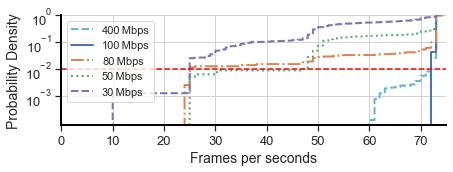

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def to_mbit(bytes):
    return (bytes * 8) / 1048576

# depricated the timestamp was at a second rate anyway.
def dataframe_add_timestamp(file_path : str, df : pd.DataFrame, col_name :str = 'time'):
    with open(file_path, 'r', encoding='utf-16') as file:
        data = []
        for line in file:
            data.append(int(float(line.split(' ')[0])))

        df.insert(0, col_name, data)


def cumulative_figure():
    df_aggregate['experiment'] = df_aggregate['experiment'].replace('', '400')
    df_some = df_aggregate[df_aggregate['device'] == 'Quest-2']
    experiment = sorted(df_some['experiment'].unique(), key=lambda x: -int(x)) 

    plt.figure(figsize=(6.4, 2.5))
    # plt.title("Quest-Pro FPS bandwidth probability density FPS")
    plt.xlim((0, 75))
    plt.xlabel("Frames per second")
    plt.ylabel("Probability Density")

    colors = sns.color_palette("deep", n_colors=100)
    line_styles = ['-', '--', '-.', ':']
    i = 9
    for e in experiment:
        df_x = df_some[df_some['experiment'] == e]
        df_x = df_x[df_x['repetition'].str.contains("replay", case=False)]
        fig = sns.ecdfplot(df_x["FPS"].to_list(), label=e + "\u2009Mbps", color=colors[i], )
        print(np.percentile(df_x["FPS"], 0.5))
        i += 1
        if i == 13: i+=1

    
    fig.lines[0].set_linestyle(line_styles[1])
    fig.lines[1].set_linestyle(line_styles[0])
    fig.lines[2].set_linestyle(line_styles[2])
    fig.lines[3].set_linestyle(line_styles[3])
    fig.lines[4].set_linestyle(line_styles[1])

    for e in range(5):
        fig.lines[e].set_linewidth(2)
    
    fig.set_yscale("log")
    fig.set_yticks([1e0, 1e-1, 1e-2, 1e-3])
    fig.axhline(1e-2, color="red", linestyle=':')
    fig.legend()

    plt.tight_layout()
    plt.savefig("fps-maddness.pdf")

cumulative_figure()
